In [1]:
import h5py
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm

# librerie pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.optim import Adam
from torch.utils import data
import torch.utils.data as utils
from torch.utils.data import Dataset
from torchvision import transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()

from scipy import stats
import torchvision.models as models


In [2]:
Comp = 'FabioPC'

In [11]:
class dataset_h5(torch.utils.data.Dataset):
    
    def __init__(self, in_file, imgs_key='data', labels_key='label', transform = None, train = True):
        super(dataset_h5, self).__init__()

        self.in_file = in_file
        self.imgs_key = imgs_key
        self.labels_key = labels_key
        self.transform = transform
        if train == True:
            self.train = "train_group"
        else:
            self.train = "test_group"

    def __getitem__(self, index):
        with h5py.File(self.in_file,'r') as db:
            img_data = db.file[self.train][self.imgs_key][index]
            label = db.file[self.train][self.labels_key][index]
            if self.transform:
                img_data = self.transform(img_data)
        
        return (img_data, label, index)

    def __len__(self):
        with h5py.File(self.in_file,'r') as db:
            lens=len(db[self.train][self.labels_key])
            
        return lens

In [12]:
 with h5py.File('D:/ADNI/Dati/ADNI_T1/ADNI1_T1/ADNI_Registrate/H5Corrette/data_img_norm_bilanciate.h5','r') as db:
        print(db['label'])

OSError: Unable to open file (unable to open file: name = 'D:/ADNI/Dati/ADNI_T1/ADNI1_T1/ADNI_Registrate/H5Corrette/data_img_norm_bilanciate.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [15]:
len(dataset)

22852

In [14]:
if Comp == 'FabioPC':
    dataset = dataset_h5('/media/fabio/Disco locale/Fabio/Programmazione/Python/Poliambulanza/Alzheimer/Dati/ADNI/ADNI_Prova/H5Corrette/data_ADNI1_with_len.h5')
else:
    dataset = dataset_h5('D:/ADNI/Dati/ADNI_T1/ADNI1_T1/ADNI_Registrate/H5Corrette/data_img_norm_intere.h5')

In [26]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
shuffle_dataset = True
random_seed= 42

In [27]:
np.random.shuffle(indices)

In [30]:
from torch.utils.data.sampler import SubsetRandomSampler
'''
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = .2
shuffle_dataset = True
random_seed= 42

split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]
print(train_indices)'''
train_sampler = SubsetRandomSampler(train_indices)
#valid_sampler = SubsetRandomSampler(val_indices)

In [31]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=5, 
                                           sampler=train_sampler)

In [32]:
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=3,
                                                sampler=valid_sampler)

In [10]:
#loader_params = {'batch_size': 15, 'shuffle': False, 'num_workers': 0}

In [11]:
#data_loader = data.DataLoader(dataset, **loader_params)

In [105]:
#data_loader.dataset.get_data("data",0).shape

In [106]:
#data_loader.dataset.get_data_infos("data")

In [44]:
counter_1 = 0
counter_2 = 0
counter_3 = 0
for batch_index, (img, labels, index) in enumerate(train_loader):
    for label in labels:
        if (label.numpy() == [1, 0,0]).all():
            counter_1 += 1
        elif (label.numpy() == [0, 1, 0]).all():
            counter_2 += 1
        else:
            counter_3 += 1
            
print(counter_1)
print(counter_2)
print(counter_3)

4013
5316
8953


In [ ]:
#dataset.data_cache_size

In [17]:
labels

tensor([[0., 1., 0.]])

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])


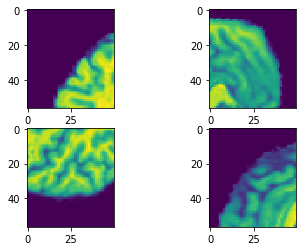

In [34]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img[0][30,:,:])
axs[0, 1].imshow(img[1][20,:,:])
axs[1, 0].imshow(img[2][20,:,:])
axs[1, 1].imshow(img[3][20,:,:])
print(labels)

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1,32, kernel_size=(4, 4, 3))
        self.conv2 = nn.Conv3d(32, 32, kernel_size=(3, 3, 3), padding=(1,1,1))
        self.bn1 = nn.BatchNorm3d(num_features=32)
        
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 4, 3))
        self.conv4 = nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding = (1,1,1))
        self.bn2 = nn.BatchNorm3d(num_features=64)
        
        self.conv5 = nn.Conv3d(64, 128, kernel_size=(3, 3, 4))
        self.conv6 = nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding = (1,1,1))
        self.bn3 = nn.BatchNorm3d(num_features=128)
        
        self.conv7 = nn.Conv3d(128, 256, kernel_size=(2, 2, 3))
        #self.bn4 = nn.BatchNorm3d(num_features=256)
        
        
        
        
        self.fc1 = nn.Linear( 256*2, 350) # 3 * 5 * 4 * 256
        self.bn5 = nn.BatchNorm1d(num_features=350)
        self.fc2 = nn.Linear(350, 250)
        self.bn6 = nn.BatchNorm1d(num_features=250)
        self.fc3 = nn.Linear(250, 50)
        self.bn7 = nn.BatchNorm1d(50)
        self.fc4 = nn.Linear(50,3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool3d(F.relu(self.bn1(self.conv2(x))), (2, 2, 2))
        x = self.conv3(x)
        x = F.max_pool3d(F.relu(self.bn2(self.conv4(x))), (2, 2, 2))
        x = self.conv5(x)
        x =F.max_pool3d(F.relu(self.bn3(self.conv6(x))), (2, 2, 2))
        x =F.max_pool3d(F.relu((self.conv7(x))), (2, 2, 2))
            
            
        
        x = x.view(-1,256*2)
        x = F.relu(self.bn5(self.fc1(x)))
        x = F.relu(self.bn6(self.fc2(x)))
        x = F.relu(self.bn7(self.fc3(x)))
        x = self.fc4(x)
        return F.softmax(x)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = Net().to(device)

In [47]:
import torch.optim as optim
weights = [counter_1/counter_1, counter_1/counter_2, counter_1/counter_3]
class_weights = torch.FloatTensor(weights).cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [48]:
acc = []
loss = []
for i in range(0,50):
    
    loss_list, batch_list = [], []
    total_acc = 0
    total_loss = 0
    
    for num, (img, label, index) in enumerate(train_loader):
        
        total = 0
        correct=0
        
        inputs = img.unsqueeze(1)
        #print(inputs.shape)
        label = np.argmax(label, axis=1)
        
        optimizer.zero_grad()
        

        output = model(inputs.float().to(torch.device("cuda" if torch.cuda.is_available() else "cpu")))
        loss = criterion(output, label.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype= torch.long))
        _, predicted = torch.max(output, 1)
        #print()
        
        
        total += label.size(0)
        correct += (predicted == label.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))).sum().item()
        
        
        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)
        loss.backward()
        optimizer.step()
        
        total_acc +=correct
        total_loss += loss.detach().cpu().item()
        if num%1==0:
            print('Train - Epoch %d, Batch: %d, Loss: %f, Acc: %d' % (i, num, loss.detach().cpu().item(), correct))
    print('ACC = ' +str(total_acc/156))
    print('Loss = ' + str(total_loss/156))
    acc.append(total_acc/156)
    loss.append(total_loss/156)
    

/home/fabio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train - Epoch 0, Batch: 0, Loss: 1.024839, Acc: 4
Train - Epoch 0, Batch: 1, Loss: 1.058896, Acc: 3
Train - Epoch 0, Batch: 2, Loss: 1.118672, Acc: 1
Train - Epoch 0, Batch: 3, Loss: 1.088847, Acc: 2
Train - Epoch 0, Batch: 4, Loss: 1.141752, Acc: 1
Train - Epoch 0, Batch: 5, Loss: 1.174554, Acc: 0
Train - Epoch 0, Batch: 6, Loss: 1.092556, Acc: 2
Train - Epoch 0, Batch: 7, Loss: 1.111255, Acc: 2
Train - Epoch 0, Batch: 8, Loss: 1.113048, Acc: 1
Train - Epoch 0, Batch: 9, Loss: 1.112793, Acc: 2
Train - Epoch 0, Batch: 10, Loss: 1.126040, Acc: 2
Train - Epoch 0, Batch: 11, Loss: 1.120655, Acc: 2
Train - Epoch 0, Batch: 12, Loss: 1.069768, Acc: 3
Train - Epoch 0, Batch: 13, Loss: 1.131420, Acc: 0
Train - Epoch 0, Batch: 14, Loss: 1.177393, Acc: 1
Train - Epoch 0, Batch: 15, Loss: 1.107404, Acc: 2
Train - Epoch 0, Batch: 16, Loss: 1.078383, Acc: 4


KeyboardInterrupt: 

In [ ]:
label

In [ ]:
np.argmax(label, axis=1)

In [ ]:
PATH = os.getcwd() + '/LeNet5_CNN.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

In [ ]:
dataiter = iter(validation_loader)

In [ ]:
images, labels = dataiter.next()

In [ ]:
asd

In [ ]:
total = 0
correct=0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        print(labels)
        outputs = net(images.unsqueeze(1).float().to(torch.device("cuda" if torch.cuda.is_available() else "cpu")))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        print(predicted.to("cpu"))
        correct += (predicted.to("cpu") == np.argmax(labels, axis=1)).sum().item()
        print(correct)

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))